The main steps in this subsection are as follows:

1. **Read JSON file and create DataFrame**:
   - Use PySpark to read the JSON file and then convert it into a DataFrame.
   - Expand the game array for further processing.

2. **Data Cleaning**:
   - Filter out users with zero or missing games.
   - Handle missing game names and game times by filling game names with "Unknown" and game times with zeros.
   - Remove outliers with more than 10,000 hours of game time.

3. **Save the cleaned DataFrame to a JSON file**. 4.

4. **Display the cleaned Data**:
   - Display the cleaned DataFrame of game data.

5. **Analysis and Visualization**:
   - Calculate the number of owners for each game and display the top 30 most popular games.
   - Calculates the average play time for each game and displays the top 30 games with the highest average play time.

6. **User grouping**:
   - Calculate the total game time for each user.
   - Calculate the quartiles of game time to determine the basis for grouping.
   - Create an Activity Grouping column to group users into groups with different levels of activity.
   - Displays statistics on the number of users in each activity group.

7. **Save the DataFrame of the grouped users to a JSON file**.


In [11]:
'''2.1.1. Read JSON file and create DataFrame'''
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, when

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Steam User games Data Cleaning") \
    .getOrCreate()

# Read JSON file
df = spark.read.json("/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Data/user_owned_games.json")

# Explode the games array
df_games = df.select(col("steamid"), explode(col("games")).alias("game_details"))

# Create a more intuitive DataFrame, and remove img_icon_url at the same time
games_df = df_games.select(
    col("steamid"),
    col("game_details.appid").alias("appid"),
    col("game_details.name").alias("name"),
    col("game_details.playtime_forever").alias("playtime_forever")
)


In [12]:
'''2.1.2. Data Cleaning Steps
a. Filter out users with zero or missing game counts'''
clean_df = df.filter(col("game_count") > 0)


In [13]:
'''b. Handle missing game names or playtime'''
from pyspark.sql.functions import isnull

# Fill missing game names and playtime
games_df = games_df.withColumn("name", when(isnull(col("name")), "Unknown").otherwise(col("name")))
games_df = games_df.withColumn("playtime_forever", when(isnull(col("playtime_forever")), 0).otherwise(col("playtime_forever")))


In [14]:
'''c. Remove outliers'''

# Any playtime exceeding 10000 hours for a game is considered an outlier
games_df = games_df.filter(col("playtime_forever") <= 10000)


In [9]:
# '''d. Save DataFrame to CSV file'''
# output_path = "/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/games_clean.csv"
# games_df.write.csv(output_path, header=True, mode="overwrite")


In [15]:
'''d. Save DataFrame to JSON file'''
output_json_path = "/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/games_clean.json"
games_df.write.json(output_json_path, mode="overwrite")

In [10]:
'''2.1.3. Display the cleaned data'''
games_df.show()


+-----------------+-----+--------------------+----------------+
|          steamid|appid|                name|playtime_forever|
+-----------------+-----+--------------------+----------------+
|76561197960434622|   10|      Counter-Strike|              39|
|76561197960434622|   20|Team Fortress Cla...|               3|
|76561197960434622|   30|       Day of Defeat|               6|
|76561197960434622|   40|  Deathmatch Classic|               0|
|76561197960434622|   50|Half-Life: Opposi...|              52|
|76561197960434622|   60|            Ricochet|              59|
|76561197960434622|   70|           Half-Life|             725|
|76561197960434622|  130|Half-Life: Blue S...|              72|
|76561197960434622|   80|Counter-Strike: C...|               0|
|76561197960434622|  100|Counter-Strike: C...|               0|
|76561197960434622|  220|         Half-Life 2|            1112|
|76561197960434622|  240|Counter-Strike: S...|              48|
|76561197960434622|  280|   Half-Life: S

+--------------------+-----+
|                name|count|
+--------------------+-----+
|Grand Theft Auto:...| 4488|
|Grand Theft Auto:...| 3900|
|         Tomb Raider| 3791|
|            Portal 2| 3763|
|Grand Theft Auto III| 3698|
|       Left 4 Dead 2| 3682|
|Half-Life 2: Lost...| 3614|
|              Portal| 3520|
|         Half-Life 2| 3461|
| Company of Heroes 2| 3456|
|          Metro 2033| 3424|
|          Insurgency| 3388|
|Half-Life 2: Deat...| 3382|
|           Half-Life| 3284|
|            PAYDAY 2| 3245|
|Half-Life 2: Epis...| 3232|
|Half-Life Deathma...| 3232|
|Half-Life 2: Epis...| 3227|
|Amnesia: The Dark...| 3088|
|Killing Floor Mod...| 3083|
+--------------------+-----+


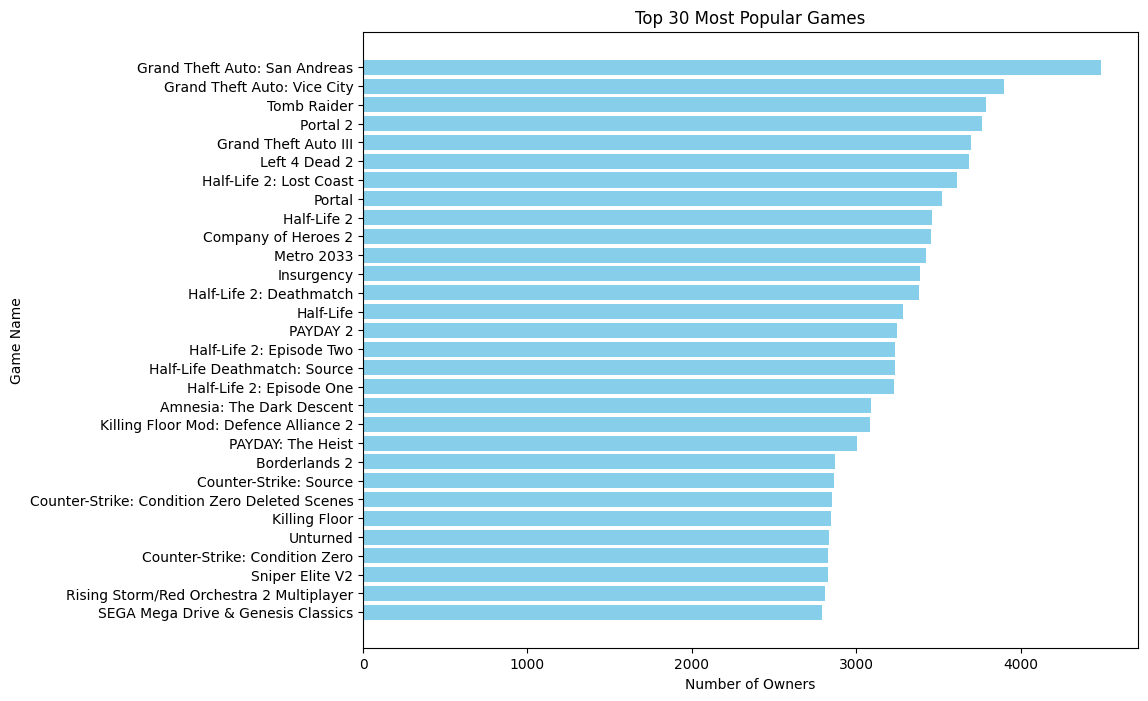

In [22]:
'''2.1.4. Analyze and visualize the number of owners for each game'''
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Calculate the number of owners for each game
game_ownership = games_df.groupBy("name").count().orderBy("count", ascending=False)

# Take the top 30 most popular games
top_30_games = game_ownership.limit(30)
top_30_games.show()

# Visualization
top_30_games_pandas = top_30_games.toPandas()
plt.figure(figsize=(10, 8))
plt.barh(top_30_games_pandas['name'], top_30_games_pandas['count'], color='skyblue')
plt.xlabel('Number of Owners')
plt.ylabel('Game Name')
plt.title('Top 30 Most Popular Games')
plt.gca().invert_yaxis()
plt.show()


+--------------------+------------------+
|                name|      avg_playtime|
+--------------------+------------------+
|CyberLink PowerDi...|            8712.0|
|MAGIX Movie Edit ...|4073.6666666666665|
|Coloring Game: St...|            3882.5|
| iFAction Game Maker|3468.3333333333335|
|Empire Deluxe Com...|            3171.0|
| Audials Moviebox 12|3136.6666666666665|
|          ELDEN RING|  3101.93793911007|
|Like a Dragon: In...|3090.4102564102564|
|    Logiart Grimoire|3014.3333333333335|
|  Grand Theft Auto V|2969.4572833435773|
|Minesweeper: Coll...|            2946.0|
|      Cyberpunk 2077|2889.0380549682877|
|The Legend of Her...|            2886.5|
|     Baldur's Gate 3|2733.4505005561737|
|Movavi Video Edit...|2637.3333333333335|
|          Ikki Unite| 2551.714285714286|
|   LOGistICAL: Japan|2520.8888888888887|
|           Starfield|2467.2494279176203|
|      Cookie Clicker| 2465.757785467128|
|The Elder Scrolls...| 2452.618426770969|
+--------------------+------------

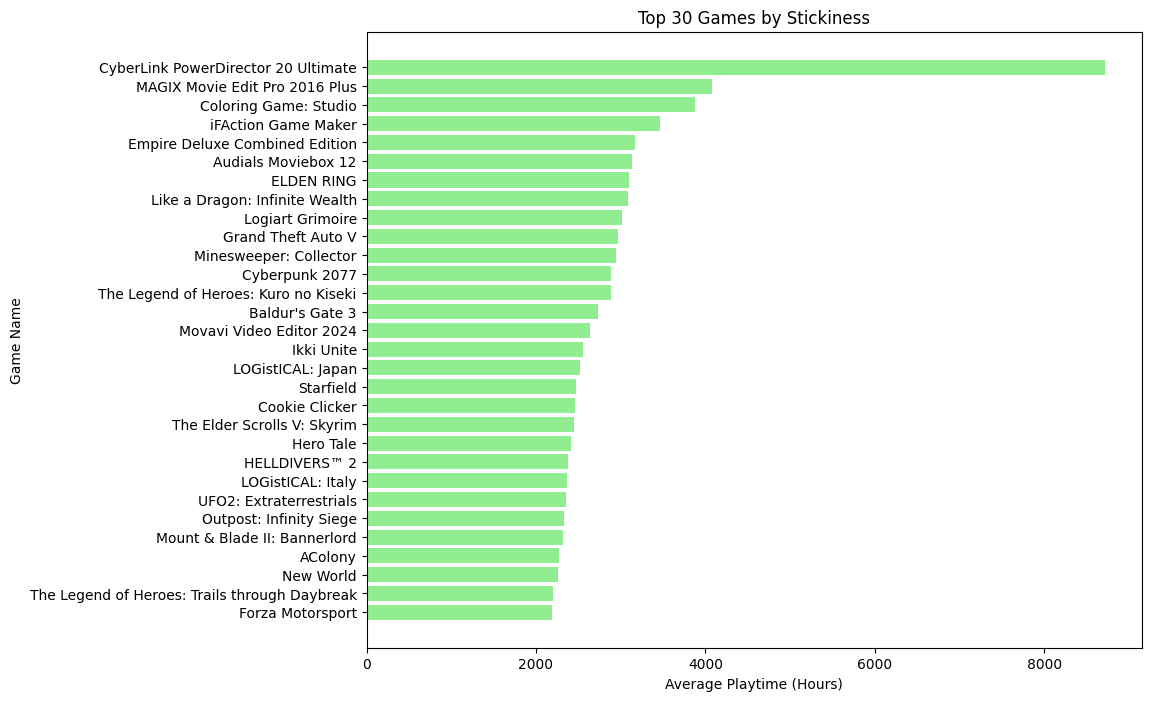

In [23]:
'''2.1.5. Calculate and visualize the average playtime for each game'''
# Calculate the average playtime for each game
avg_playtime = games_df.groupBy("name").agg(F.avg("playtime_forever").alias("avg_playtime")).orderBy("avg_playtime", ascending=False)

# Take the top 30 games with the highest average playtime
top_30_sticky_games = avg_playtime.limit(30)
top_30_sticky_games.show()

# Visualization
top_30_sticky_games_pandas = top_30_sticky_games.toPandas()
plt.figure(figsize=(10, 8))
plt.barh(top_30_sticky_games_pandas['name'], top_30_sticky_games_pandas['avg_playtime'], color='lightgreen')
plt.xlabel('Average Playtime (Hours)')
plt.ylabel('Game Name')
plt.title('Top 30 Games by Stickiness')
plt.gca().invert_yaxis()
plt.show()


In [16]:
'''2.1.6. Group users by playtime'''
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("user_groups") \
    .getOrCreate()

# Calculate total playtime for each user
user_total_playtime = games_df.groupBy("steamid").agg(F.sum("playtime_forever").alias("total_playtime"))

# Calculate quantiles for grouping
quantiles = user_total_playtime.stat.approxQuantile("total_playtime", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 0.0)

# Grouping function
def assign_group(value):
    for i, q in enumerate(quantiles):
        if value <= q:
            return i + 1  # Grouping starts from 1
    return len(quantiles) + 1

# Register UDF
assign_group_udf = F.udf(assign_group, IntegerType())

# Apply UDF to create an activity group column
user_total_playtime = user_total_playtime.withColumn("activity_group", assign_group_udf(F.col("total_playtime")))

# Display the counts after grouping
activity_counts_filtered = user_total_playtime.groupBy("activity_group").count().orderBy("activity_group")
activity_counts_filtered.show()

# Save DataFrame as JSON
output_path = "/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/filtered_user_groups.json"  # Replace with your actual path
user_total_playtime.write.mode('overwrite').json(output_path)


+--------------+-----+
|activity_group|count|
+--------------+-----+
|             1|  472|
|             2|  471|
|             3|  472|
|             4|  471|
|             5|  471|
|             6|  472|
|             7|  471|
|             8|  472|
|             9|  471|
|            10|  471|
+--------------+-----+
